## RNN Time Series Implementation

In [1]:
# Importing the Libraries
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Data from Federal Reserve Economic Database (FRED)[https://fred.stlouisfed.org/]
filename = 'Data/Alcohol_sales.csv'

In [3]:
df = pd.read_csv(filename, index_col = 0, parse_dates = True)

In [10]:
df.head()
# monthly increments

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df = df.dropna()

In [14]:
len(df)

325

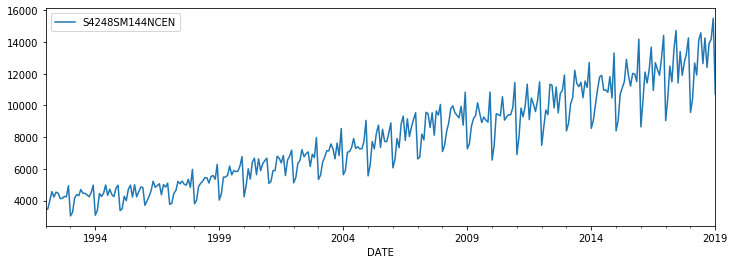

In [17]:
df.plot(figsize = (12, 4))
# clear seasonality 
# general upward trend

In [5]:
y = df['S4248SM144NCEN'].values.astype(float)

In [6]:
# Using 1 year as a test size
test_size = 12

In [7]:
train = y[:-test_size]
test = y[-test_size:]

In [8]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train.reshape(-1,1))

In [9]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [10]:
# Hyperparams
seq_size = 12
hidden_dim = 100
lr = 0.001
epochs = 100

In [11]:
# prepare data for LSTM
def prep_data(seq, ss):
    output = []
    l = len(seq)
    
    for i in range(l - ss):
        data = seq[i:i+ss]
        label = seq[i+ss:i+ss+1]
        output.append((data,label))
    
    return output

In [12]:
train_data = prep_data(train_norm, seq_size)

In [38]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [13]:
# Model
class LSTM(nn.Module):
    def __init__(self, input_dim = 1, hidden_dim = hidden_dim, output_dim = 1):
        
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        
        self.hidden = (torch.zeros(1,1,hidden_dim), torch.zeros(1,1,hidden_dim))
    
    def forward(self, seq):
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.fc1(lstm_out.view(len(seq), -1))
        
        return pred[-1]

In [14]:
# Initialise 
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [45]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [15]:
import time
start_time = time.time()

for i in range(epochs):
    for  seq, y_train in train_data:
        
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1,1,model.hidden_dim),torch.zeros(1,1,model.hidden_dim))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # training result
    print(f'Epoch: {i+1:2} | Loss: {loss.item():10.8f}')


total_time = time.time() - start_time
print(f'Total time: {total_time}')

Epoch:  1 | Loss: 0.27248755
Epoch:  2 | Loss: 0.32762596
Epoch:  3 | Loss: 0.32924265
Epoch:  4 | Loss: 0.36256662
Epoch:  5 | Loss: 0.30847666
Epoch:  6 | Loss: 0.31417939
Epoch:  7 | Loss: 0.31545597
Epoch:  8 | Loss: 0.32205725
Epoch:  9 | Loss: 0.31937715
Epoch: 10 | Loss: 0.30220604
Epoch: 11 | Loss: 0.30915058
Epoch: 12 | Loss: 0.28652900
Epoch: 13 | Loss: 0.28415266
Epoch: 14 | Loss: 0.28143200
Epoch: 15 | Loss: 0.26257938
Epoch: 16 | Loss: 0.23248108
Epoch: 17 | Loss: 0.24778540
Epoch: 18 | Loss: 0.16151251
Epoch: 19 | Loss: 0.27016926
Epoch: 20 | Loss: 0.11126789
Epoch: 21 | Loss: 0.25012836
Epoch: 22 | Loss: 0.06640366
Epoch: 23 | Loss: 0.05677374
Epoch: 24 | Loss: 0.00383501
Epoch: 25 | Loss: 0.05554101
Epoch: 26 | Loss: 0.02816108
Epoch: 27 | Loss: 0.01083947
Epoch: 28 | Loss: 0.03338278
Epoch: 29 | Loss: 0.01365956
Epoch: 30 | Loss: 0.00927323
Epoch: 31 | Loss: 0.00048963
Epoch: 32 | Loss: 0.00543657
Epoch: 33 | Loss: 0.00108339
Epoch: 34 | Loss: 0.01143666
Epoch: 35 | Lo

In [16]:
future = 12
preds = train_norm[-seq_size:].tolist()

model.eval()

# test loss against predicitons
preds = train[-seq_size:].tolist()

for f in range(future):  
    seq = torch.FloatTensor(preds[-seq_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_dim),torch.zeros(1,1,model.hidden_dim))
            
        preds.append(model(seq).item())

In [17]:
preds[seq_size:]
# prediction values normalised

[-0.7621440291404724,
 0.16326914727687836,
 0.26384779810905457,
 0.4880482852458954,
 0.8100023865699768,
 0.8044789433479309,
 0.5004511475563049,
 0.07444095611572266,
 -0.05780467018485069,
 0.6834487318992615,
 0.5540538430213928,
 0.8134320378303528]

In [18]:
true_preds = scaler.inverse_transform(np.array(preds[seq_size:]).reshape(-1,1))

In [19]:
true_preds

array([[ 4422.33850154],
       [ 9835.542877  ],
       [10423.87769504],
       [11735.33844455],
       [13618.60896024],
       [13586.29957911],
       [11807.88898763],
       [ 9315.9423728 ],
       [ 8542.37158175],
       [12878.33335724],
       [12121.43795475],
       [13638.67070529]])

In [20]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [21]:
x = np.arange('2018-02-01','2019-02-01', dtype = 'datetime64[M]')

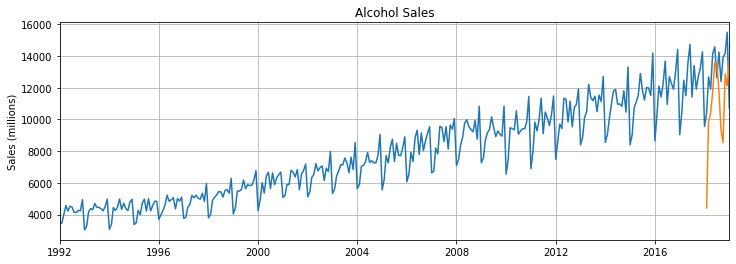

In [22]:
# plot predicitons
plt.figure(figsize=(12, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (millions)')
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_preds)
plt.show()

In [24]:
# ???